In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
rootpath = "C:\\Users\\csmuser\\Desktop\\Spandan_Suthar_Research\\transformer_quantum_state"
os.chdir(rootpath)

In [6]:
import torch
import os
import numpy as np

from hamiltonians.Hamiltonian import Hamiltonian
from hamiltonians.Ising import Ising
from model.model import TransformerModel
from model.model_utils import sample

## Hardware Setup

In [7]:
def gpu_setup():
    # Setup for PyTorch:
    if torch.cuda.is_available():
        torch_device = torch.device("cuda")
        print("PyTorch is using GPU {}".format(torch.cuda.current_device()))
    else:
        torch_device = torch.device("cpu")
        print("GPU unavailable; using CPU")

In [8]:
gpu_setup()
torch.set_default_device("cuda")
torch.set_default_dtype(torch.float32)

PyTorch is using GPU 0


## Model Setup

In [9]:
system_sizes = torch.arange(15, 15 + 2, 2).reshape(-1, 1)
Hamiltonians = [Ising(size, periodic=True, get_basis=False) for size in system_sizes]
param_dim = Hamiltonians[0].param_dim
embedding_size = 32
n_head = 8
n_hid = embedding_size
n_layers = 8
dropout = 0
minibatch = 10000
param_range = None
point_of_interest = None
use_SR = False

c:\Users\csmuser\anaconda3\envs\tqs2\Lib\site-packages\torch\utils\_device.py:79: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3701.)
  return func(*args, **kwargs)
c:\Users\csmuser\anaconda3\envs\tqs2\Lib\site-packages\torch\utils\_device.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


In [10]:
model = TransformerModel(
    system_sizes,
    param_dim,
    embedding_size,
    n_head,
    n_hid,
    n_layers,
    dropout=dropout,
    minibatch=minibatch,
)

model.cuda()

results_dir = "supervised_results"
paper_checkpoint_name = "ckpt_3400_Ising_32_8_8_0_supervised.ckpt"
paper_checkpoint_path = os.path.join(results_dir, paper_checkpoint_name)
checkpoint = torch.load(paper_checkpoint_path)
model.load_state_dict(checkpoint)

c:\Users\csmuser\anaconda3\envs\tqs2\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\csmuser\AppData\Local\Temp\ipykernel_28520\2939741192.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they 

<All keys matched successfully>

In [11]:
def extract_energy_estimate(
    model,
    H: Hamiltonian,
    param: torch.Tensor,
    num_samples: int = 1000000,
    max_unique: int = 100,
):
    """
    Extracts an energy estimate from the model using the Hamiltonian H.
    Parameters:
        H: Hamiltonian
            The Hamiltonian object to use to produce the energy estimate
        param: torch.Tensor
            The parameters to obtain the energy estimate for
        num_samples: int
            The number of samples from the wave function the model represents to use
            in energy estimation
        max_unique: int
            The maximum number of unique samples to generate (see sample in model_utils.py)
    """
    model.set_param(system_size=H.system_size, param=param)
    symmetry = H.symmetry
    samples, sample_weight = sample(model, num_samples, max_unique, symmetry)
    E = H.Eloc(samples, sample_weight, model, use_symmetry=True)
    E_mean = (E * sample_weight).sum()
    E_var = (
        (((E - E_mean).abs() ** 2 * sample_weight).sum() / H.n**2)
        .detach()
        .cpu()
        .numpy()
    )
    Er = (E_mean.real / H.n).detach().cpu().numpy()
    Ei = (E_mean.imag / H.n).detach().cpu().numpy()

    return E_mean, E_var, Er, Ei

In [19]:
drmg40path = os.path.join("results", "E_dmrg_40.npy")
dmrg40 = np.load(drmg40path)
dmrg40 = torch.tensor(dmrg40, dtype=torch.float32)

ising40 = Ising(
    torch.tensor([40]),
    periodic=False,
    get_basis=False,
)

dmrg40_h_values = torch.linspace(0, 2, 101)
oneidx = torch.where(dmrg40_h_values == 1.0)[0][0]

c:\Users\csmuser\anaconda3\envs\tqs2\Lib\site-packages\torch\utils\_device.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


In [21]:
dmrg40_h_values

tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
        0.1800, 0.2000, 0.2200, 0.2400, 0.2600, 0.2800, 0.3000, 0.3200, 0.3400,
        0.3600, 0.3800, 0.4000, 0.4200, 0.4400, 0.4600, 0.4800, 0.5000, 0.5200,
        0.5400, 0.5600, 0.5800, 0.6000, 0.6200, 0.6400, 0.6600, 0.6800, 0.7000,
        0.7200, 0.7400, 0.7600, 0.7800, 0.8000, 0.8200, 0.8400, 0.8600, 0.8800,
        0.9000, 0.9200, 0.9400, 0.9600, 0.9800, 1.0000, 1.0200, 1.0400, 1.0600,
        1.0800, 1.1000, 1.1200, 1.1400, 1.1600, 1.1800, 1.2000, 1.2200, 1.2400,
        1.2600, 1.2800, 1.3000, 1.3200, 1.3400, 1.3600, 1.3800, 1.4000, 1.4200,
        1.4400, 1.4600, 1.4800, 1.5000, 1.5200, 1.5400, 1.5600, 1.5800, 1.6000,
        1.6200, 1.6400, 1.6600, 1.6800, 1.7000, 1.7200, 1.7400, 1.7600, 1.7800,
        1.8000, 1.8200, 1.8400, 1.8600, 1.8800, 1.9000, 1.9200, 1.9400, 1.9600,
        1.9800, 2.0000], device='cuda:0')

In [23]:
num_readings = 10
predicted_energies = torch.zeros(dmrg40_h_values.shape[0], num_readings)

In [25]:
for j in range(num_readings):
    for i, param in enumerate(dmrg40_h_values):
        param_tens = torch.tensor([param], dtype=torch.float32)
        E_mean, E_var, Er, Ei = extract_energy_estimate(model, ising40, param_tens)
        predicted_energies[i, j] = E_mean
        print(f"Predicted energy for h = {param}: {E_mean}")
    

Predicted energy for h = 0.0: (-38.22600555419922+0j)
Predicted energy for h = 0.019999999552965164: (-35.13833236694336-0.0049316915683448315j)
Predicted energy for h = 0.03999999910593033: (-38.43000030517578+0.004540031775832176j)
Predicted energy for h = 0.05999999865889549: (-35.72714614868164+0.003072398714721203j)
Predicted energy for h = 0.07999999821186066: (-38.74897384643555+0.00995524600148201j)
Predicted energy for h = 0.09999999403953552: (-37.76227569580078-0.01128955278545618j)
Predicted energy for h = 0.11999999731779099: (-36.51825714111328-0.0025578285567462444j)
Predicted energy for h = 0.14000000059604645: (-39.344635009765625+0.01688580960035324j)
Predicted energy for h = 0.1599999964237213: (-39.404823303222656+0.01819194108247757j)
Predicted energy for h = 0.17999999225139618: (-39.58441925048828+0.02098819799721241j)
Predicted energy for h = 0.19999998807907104: (-37.57926559448242-0.027526382356882095j)
Predicted energy for h = 0.2199999988079071: (-39.7163200

In [26]:
avg_predicted_energies = predicted_energies.mean(dim=1)

In [27]:
avg_predicted_energies

tensor([-37.2859, -36.7963, -37.2650, -35.6410, -37.9113, -37.3690, -38.5232,
        -37.7806, -38.4096, -38.8428, -38.4179, -38.6120, -39.1886, -39.6912,
        -39.8209, -39.7287, -40.0327, -39.8317, -40.0555, -40.5418, -40.6852,
        -40.7253, -41.0876, -41.2737, -41.4240, -41.6848, -41.8993, -42.1081,
        -42.3589, -42.5945, -42.8826, -43.1107, -43.4292, -43.7227, -44.0580,
        -44.3502, -44.6678, -44.9723, -45.3393, -45.6705, -46.0930, -46.4421,
        -46.8451, -47.2629, -47.6957, -48.1147, -48.5689, -49.0307, -49.5094,
        -50.0454, -50.5863, -51.1598, -51.6892, -52.2618, -52.8144, -53.4114,
        -54.0231, -54.6447, -55.2481, -55.8844, -56.5315, -57.1604, -57.8198,
        -58.4793, -59.1417, -59.8101, -60.4881, -61.1533, -61.8325, -62.5137,
        -63.2046, -63.8959, -64.5852, -65.2878, -65.9864, -66.6893, -67.3983,
        -68.1185, -68.8209, -69.5335, -70.2467, -70.9669, -71.6856, -72.3957,
        -73.1305, -73.8599, -74.5899, -75.3291, -76.0324, -76.78

In [28]:
predicted_energies.view(-1)

tensor([-38.2260, -34.7858, -35.0113,  ..., -84.9040, -84.9188, -84.9290],
       device='cuda:0')

In [29]:
relative_error = torch.abs((avg_predicted_energies.view(-1) - dmrg40) / dmrg40)

In [30]:
relative_error

tensor([4.3952e-02, 5.6606e-02, 4.4898e-02, 8.7013e-02, 2.9587e-02, 4.4396e-02,
        1.6045e-02, 3.6358e-02, 2.1891e-02, 1.2663e-02, 2.5448e-02, 2.2725e-02,
        1.0566e-02, 5.4791e-04, 1.6675e-04, 5.5560e-03, 1.2446e-03, 9.7345e-03,
        7.8571e-03, 2.6419e-04, 3.2422e-04, 3.6549e-03, 6.7319e-04, 4.6715e-04,
        8.2260e-04, 3.2983e-04, 1.3950e-04, 4.0995e-04, 1.8584e-04, 5.4994e-04,
        8.3359e-05, 9.1084e-04, 4.5410e-05, 2.9664e-06, 7.6312e-04, 3.0010e-04,
        1.6648e-04, 5.0072e-04, 3.0877e-05, 6.0679e-04, 5.5050e-04, 1.6154e-04,
        1.5880e-05, 2.1846e-04, 4.3264e-04, 3.8454e-05, 3.4795e-05, 1.7852e-04,
        4.3176e-04, 8.7285e-05, 3.3327e-04, 8.9005e-04, 2.9337e-04, 2.8541e-04,
        3.2507e-04, 2.9460e-04, 1.7043e-04, 3.3368e-05, 3.7568e-04, 2.5734e-04,
        7.7730e-05, 3.3304e-04, 1.6168e-04, 9.0272e-05, 6.2304e-05, 1.9134e-05,
        1.0407e-04, 5.9382e-05, 6.0888e-05, 9.3965e-05, 3.3918e-05, 2.3761e-05,
        9.9455e-05, 1.8814e-05, 4.8790e-

In [31]:
relative_error.max()

tensor(0.0870, device='cuda:0')

old estimates:

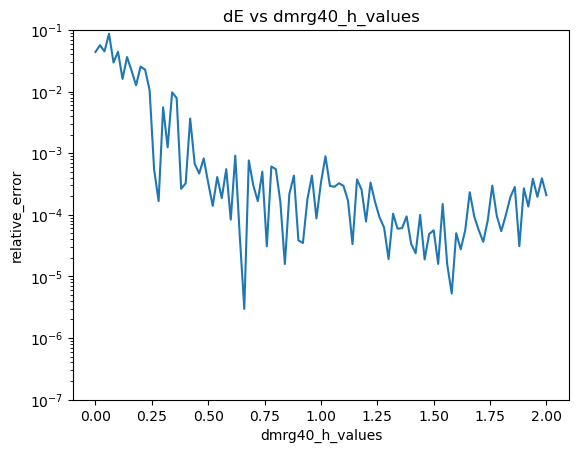

In [33]:
import matplotlib.pyplot as plt

plt.plot(dmrg40_h_values.cpu(), relative_error.cpu())
plt.xlabel('dmrg40_h_values')
plt.ylabel('relative_error')
plt.title('dE vs dmrg40_h_values')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.ylim(1e-7, 1e-1)  # Set y-axis range
plt.show()

new estimates:

In [ ]:
import matplotlib.pyplot as plt

plt.plot(dmrg40_h_values.cpu(), relative_error.cpu())
plt.xlabel('dmrg40_h_values')
plt.ylabel('predicted_energies')
plt.title('dE vs dmrg40_h_values')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.ylim(1e-7, 1e-1)  # Set y-axis range
plt.show()